# Dataset: Credit Card Classification - clean data
##### source: https://www.kaggle.com/datasets/samuelcortinhas/credit-card-classification-clean-data

## 1. Description
The dataset we employed is composed of 9709 rows x 20 columns representing different clients of a credit card service.
From the few information that are provided on the dataset, we know that it has been obtained by processing another original dataset and we can assume all the data come from chinese clients, since currency is expressed in yuan. No critical personal information is proposed, except for the client'IDs.
<br>The attributes represented by each column are:
- ID: the client ID in the database
- **Gender**: A boolean variable indicating the gender of the client, where 0 = "female" and 1 = "male"
- **Own_car**: A boolean variable indicating whether the client owns a car (1) or not (0)
- **Own_property**: A boolean variable indicating whether the client owns property (1) or not (0)
- Work_phone: A boolean variable indicating whether the client owns a work phone (1) or not (0)
- Phone: A boolean variable indicating whether the client owns a phone (1) or not (0)
- Email: A boolean variable indicating whether the client owns a email address (1) or not (0)
- **Unemployed**: A boolean variable indicating whether the client is currently unemployed from his work (1) or not (0)
- Num_children: Integer variable indicating the number of children the client has
- **Num_family**: Integer variable indicating the number of members in the family of the client
- **Account_length**: Integer variables representing the number of months of credit card ownership
- **Total_income**: Integer variable indicating the total annual income of the client in terms of chinese yuan (CNY). (ed: to current date 1 CNY ~ 0.14€)
- **Age**: Float variable indicating the age of the client. The unusual data type is due to the fact that it was obtained by means of a timestamp transformation from the original dataset.
- Years_employed: Float variable indicating the number of years of employment of the client (if employed).
- **Income_type**: Discrete string variable indicating the source of income for each client, independently from the value of "Unemployed". It has 5 different values: 'Working', 'Commercial associate', 'Pensioner', 'State servant' and 'Student'.
- **Education_type**: Discrete string variable indicating the maximum level of education achieved by the client, with 5 different values: 'Lower secondary' (Attended up to middle school), 'Secondary / secondary special' (Attended up to High School), 'Incomplete higher' (left college), 'Higher education'(Attended up to college), 'Academic degree' (Obtained Ph.D.) 
- **Family_status**: Discrete string variable indicating the marital status of the client, with 5 different values: 'Civil marriage', 'Married', 'Single / not married', 'Separated', 'Widow'.
- Housing_type: Discrete string variable indicating the housing situation of the client, with 6 different values: 'Rented apartment', 'House / apartment', 'Municipal apartment', 'With parents', 'Co-op apartment', 'Office apartment'.
- Occupation_type: Discrete string variable indicating the kind of occupation of the client, with 19 different values. Each value is auto-explicative of the occupation it indicates, with the exception of "Other", that handles specific cases.
- **Target**: Boolean variable indicating whether the client is high risk (1), that means more prone to insolvency and all its consequences, or low risk (0).

In [ ]:
import pandas as pd
import numpy as np

# Loading the dataset
url = "data/clean_data.csv"
df = pd.read_csv(url)

# Showing shape and first rows
print("Dataset shape: {}".format(df.shape))
df.head()

Dataset shape: (9709, 20)


,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


## 2. Pre-processing
### 2.1 Dropping attributes
As first pre-processing step, we decided to prune the dataset to remove columns that are either redundant (e.g. <code>Num_children</code> is somewhat contained in <code>Num_family</code>) or less informative, like <code>ID</code> or <code>phone</code>. In the end, we decided to keep only the attributes marked previously in **bold**, reducing the number of columns to 12.

In [ ]:
# df2 will act as working copy of the data we are interested in
df2 = df.drop(["ID", "Work_phone", "Phone", "Email", "Years_employed", "Occupation_type", "Housing_type", "Num_children"], axis=1)

print("New dataset size:{}".format(df2.shape))
df2.head()

New dataset size:(9709, 12)


,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,1,1,1,0,2,15,427500.0,32,Working,Higher education,Civil marriage,1
1,1,1,1,0,2,29,112500.0,58,Working,Secondary / secondary special,Married,0
2,0,0,1,0,1,4,270000.0,52,Commercial associate,Secondary / secondary special,Single / not married,0
3,0,0,1,1,1,20,283500.0,61,Pensioner,Higher education,Separated,0
4,1,1,1,0,2,5,270000.0,46,Working,Higher education,Married,0


### 2.2 Discretization and dimensionality reduction
The dataset now does not present strictly continuous quantities, but at most descrete variables with high (or infinite) cardinality domains, like <code>Age</code> or <code>Total_income</code>, which would lead to very big and less informative CPDs. So, we decided to tackle this problem by discretizing the domains according to different criteria.

First of all, we decided to discretize <code>Num_family</code> so to have four different values: '1', '2', '3' and '4+'.

In [ ]:
# function setting a defult "thresh+" value if x exceedes the value thresh, 
# or the string representation of x otherwise. This keeps consistency in the data-type
def discretize_num(x):
    if x >=thresh:
      return str(thresh) + "+"
    else:
      return str(x)

In [ ]:
# setting the desired threshold
thresh = 4

# df3 will contain the final version of the dataset
df3 = df2.copy()
print("Unique values for \"Num_family\" and respective counts:")
print(np.unique(df2["Num_family"], return_counts=True)[0])
print(np.unique(df2["Num_family"], return_counts=True)[1])

df3["Num_family"] = df2["Num_family"].apply(discretize_num)

print("New unique values for \"Num_family\" and respective counts:")
print(np.unique(df3["Num_family"], return_counts=True)[0])
print(np.unique(df3["Num_family"], return_counts=True)[1])

Unique values for "Num_family" and respective counts:
[ 1  2  3  4  5  6  7  9 15 20]
[1947 5183 1635  802  117   18    4    1    1    1]
New unique values for "Num_family" and respective counts:
['1' '2' '3' '4+']
[1947 5183 1635  944]


Then, we decided to discretize <code>Age</code> in intervals defined by steps of 10 years, starting from "less than 30" to "more than 60". The decision was also taken by watching at the histograms for the distribution and its bounds. Moreover, this operation was performed after casting the variable to integer by means of the floor function.

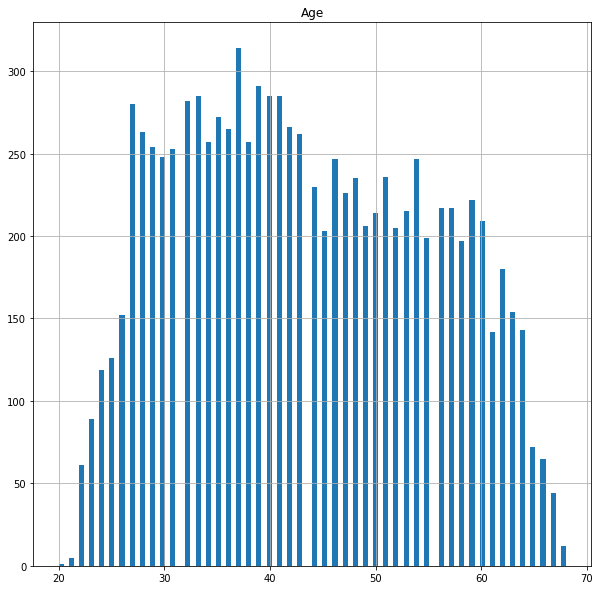

In [ ]:
df2["Age"] = df2["Age"].apply(np.floor)
df2["Age"] = df2["Age"].astype(np.int8)

df2.hist("Age", bins=100, figsize=(10,10));

In [ ]:
# function to discretize the age column
def discretize_age(x):
  if x<30:
    return "<30"
  elif x<40:
    return "30-39"
  elif x<50:
    return "40-49"
  elif x<60:
    return "50-59"
  else:
    return "60>="  

df3["Age"] = df2["Age"].apply(discretize_age)
print("New unique values for \"Age\" and respective counts:")
print(np.unique(df3["Age"], return_counts=True)[0])
print(np.unique(df3["Age"], return_counts=True)[1])

New unique values for "Age" and respective counts:
['30-39' '40-49' '50-59' '60>=' '<30']
[2724 2445 2169 1021 1350]


The next variable to discretize is <code>Total_income</code>. We chose to divide the range into three values "low", "medium" and "high". Since there isn't a trivial way to set the bounds for each bucket, we chose to apply the equi-frequency discretization function based on quantiles, provided by pandas. 

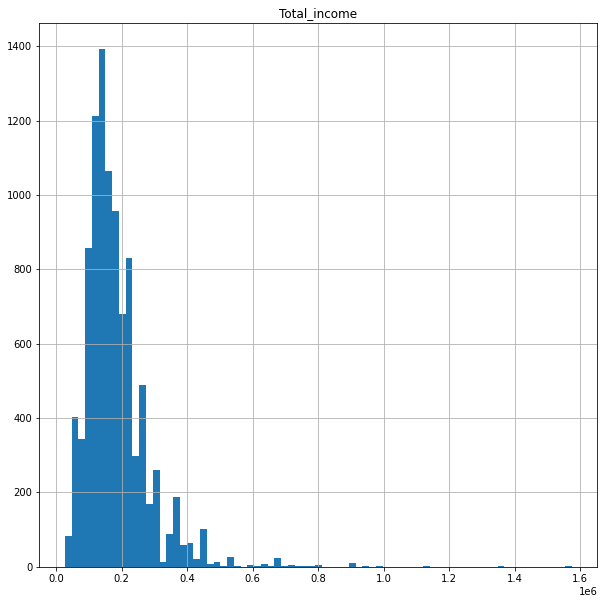

In [ ]:
df3.hist("Total_income", bins=75, figsize=(10,10));

In [ ]:
df3["Total_income"] =  pd.qcut(df2['Total_income'], 3, labels=["low", "medium", "high"])
print("New unique values for \"Total_income\" and respective counts:")
print(np.unique(df3["Total_income"], return_counts=True)[0])
print(np.unique(df3["Total_income"], return_counts=True)[1])


New unique values for "Total_income" and respective counts:
['high' 'low' 'medium']
[2777 4078 2854]


Finally, the last column to be discretized is <code>Account_length</code>. As we have done for <code>Age</code> we used the histogram for hints, and we decided to discretize the variable in terms of interval of years: "&#60;1y", "1y-2y", "2y-3y" and "3y+"

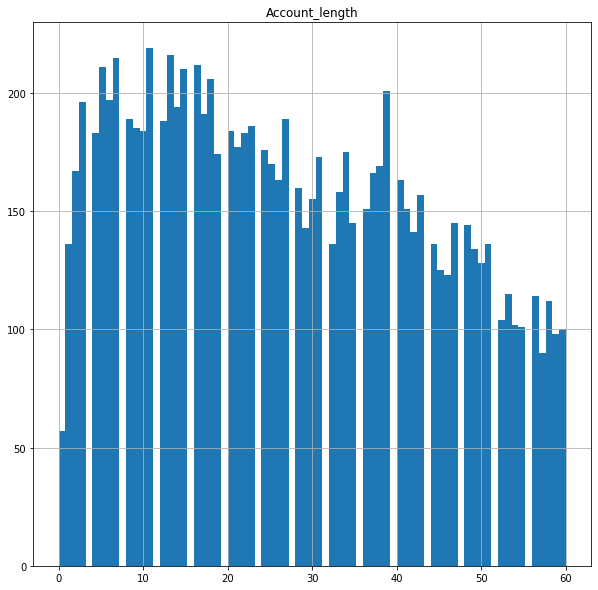

In [ ]:
df3.hist("Account_length", bins=75, figsize=(10,10));

In [ ]:
# function for account length discretiziation 
def discretize_al(x):
  if x < 12:
    return "<1y"
  elif x < 24:
    return "1y-2y"
  elif x<36:
    return "2y-3y"
  else:
    return "3y+"

df3["Account_length"] = df2["Account_length"].apply(discretize_al)
print("New unique values for \"Account_length\" and respective counts:")
print(np.unique(df3["Account_length"], return_counts=True)[0])
print(np.unique(df3["Account_length"], return_counts=True)[1])

New unique values for "Account_length" and respective counts:
['1y-2y' '2y-3y' '3y+' '<1y']
[2321 1943 3306 2139]


### 2.3 Enhanching explainability
Lastly, we decided to replace values of the boolean variables from "0" and "1" to more understandable values, so that eventual queries will be more auto-explicative

In [ ]:
df3["Gender"]       = df3["Gender"].apply(lambda x: "M" if x else "F")
df3["Own_car"]      = df3["Own_car"].apply(lambda x: "yes" if x else "no")
df3["Own_property"] = df3["Own_property"].apply(lambda x: "yes" if x else "no")
df3["Unemployed"]   = df3["Unemployed"].apply(lambda x: "yes" if x else "no")
df3["Target"]       = df3["Target"].apply(lambda x: "high risk" if x else "low risk")

In [ ]:
df3.head()

,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,M,yes,yes,no,2,1y-2y,high,30-39,Working,Higher education,Civil marriage,high risk
1,M,yes,yes,no,2,2y-3y,low,50-59,Working,Secondary / secondary special,Married,low risk
2,F,no,yes,no,1,<1y,high,50-59,Commercial associate,Secondary / secondary special,Single / not married,low risk
3,F,no,yes,yes,1,1y-2y,high,60>=,Pensioner,Higher education,Separated,low risk
4,M,yes,yes,no,2,<1y,high,40-49,Working,Higher education,Married,low risk


In [ ]:
# saving the result
df3.to_csv('data/processed.csv', encoding = 'utf-8-sig', index=False) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03282642-4d6b-431b-a45f-9f21a6236fff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>